<h2><b>0. setup</b></h2>

In [1]:
# connect to a gpu runtime in colab
# mount notebook to drive
# change the current active directory
%cd /content/drive/MyDrive/Colab\ Notebooks/squad-question-answering

/content/drive/MyDrive/Colab Notebooks/squad-question-answering


In [2]:
# Install required libs
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Import required libs
import pickle
import numpy as np
import tensorflow as tf

from model import transformer
from model import LearningRateSchedule
from dataset import Parameters
from dataset import tokens_to_text
from dataset import load_squad_dataset

<h2><b>1. define hyper-paramters</b></h2>

In [5]:
params = Parameters(
    batch_size = 32,
    vocab_size = 15_000,
    max_input_len = 170,
    max_output_len = 60,
    model_dim=256,
    num_heads=8,
    dropout_rate=0.1,
    num_units=512,
    activation="relu",
    num_layers=2,
)

for k, v in params.__dict__.items():
    print(f"{k:15}: {v}")

batch_size     : 32
vocab_size     : 15000
max_input_len  : 170
max_output_len : 60
model_dim      : 256
num_heads      : 8
dropout_rate   : 0.1
num_units      : 512
activation     : relu
num_layers     : 2


<h2><b>2.1 load dataset and tokenizer.</b></h2>

In [7]:
dataset, tokenizer, info = load_squad_dataset(params=params)

loading dataset from huggingface ...


shortening samples ...


100%|██████████| 87599/87599 [02:14<00:00, 649.54it/s]


initializing tokenizer ...
concat context with question and tokenize them ...
padding ... 


<h3><b>2.2 explore dataset.</b></h3>

In [13]:
num_batches = 0
for input_batch, target_batch in dataset:
    num_batches += 1

print(input_batch["inputs"].shape)
print(input_batch["dec_inputs"].shape)
print(target_batch.shape)

(32, 170)
(32, 59)
(32, 59)


In [9]:
for k, v in info.__dict__.items():
    print(k, type(v))

num_dropped <class 'int'>
inputs_len <class 'list'>
answers_len <class 'list'>


In [17]:
print(f"total number of the samples dropped while preparing dataset :", info.num_dropped)
print(f"total number of the training samples in our dataset         :", num_batches * params.batch_size)
print(f"total number of the samples in main squad dataset           :", info.num_dropped + num_batches * params.batch_size)

total number of the samples dropped while preparing dataset : 17901
total number of the training samples in our dataset         : 69696
total number of the samples in main squad dataset           : 87597


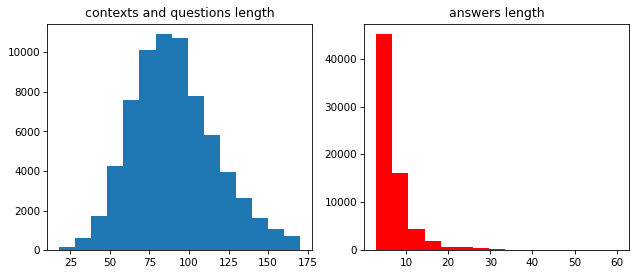

In [44]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 4), dpi=75)
plt.subplot(1, 2, 1)
_ = plt.hist(info.inputs_len, bins=15)
plt.title("contexts and questions length")

plt.subplot(1, 2, 2)
_ = plt.hist(info.answers_len, bins=15, color="red")
_ = plt.title("answers length")

<h3><b>3. build and compile the model.</b></h3>

In [45]:
# build the transformer model
qa_model = transformer(params=params)

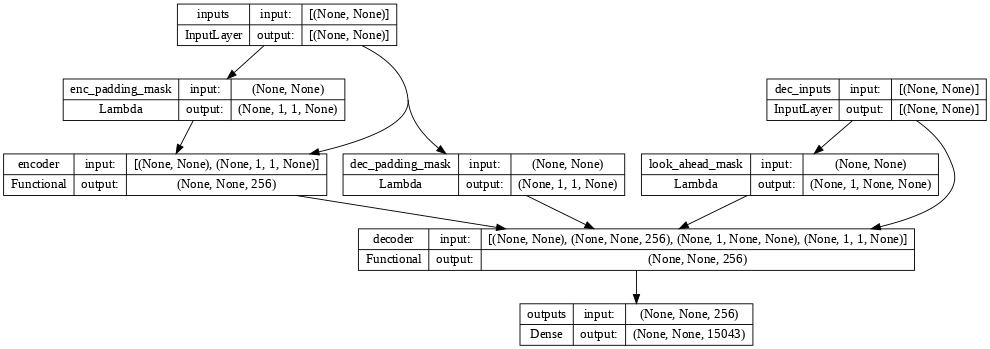

In [47]:
# plot the model architecture
from keras.utils.vis_utils import plot_model
plot_model(model=qa_model, to_file="qa_model_architecture.png", show_shapes=True, dpi=65)

In [49]:
# define loss function and accuracy
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")
def masked_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, params.max_output_len - 1))
    loss = cross_entropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, params.max_output_len - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [50]:
# optimizer 
optimizer = tf.keras.optimizers.Adam(
    LearningRateSchedule(model_dim=params.model_dim), beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

# compile the model
qa_model.compile(loss=masked_loss, optimizer=optimizer, metrics=[accuracy])

<h3><b>4. train the model</b></h3>